# Part 2: 词向量表示
（下块代码功能：如果在POS embed处运行报错，再运行以下代码可以解决）

In [ ]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()


In [2]:
import pandas as pd
import numpy as np

print('Loading data...')
# input file
train = pd.read_csv("160M_w_emo_w_split_wstop/final_data/train_160M.csv")

Loading data...


### Word Cloud绘制

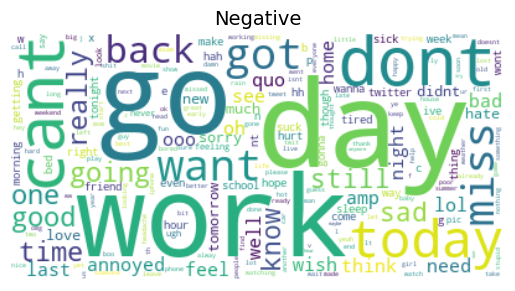

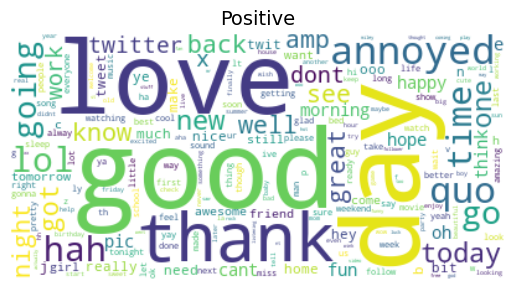

In [30]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud,ImageColorGenerator

N = train[train.neg==1].final_text
P = train[train.pos==1].final_text 
N = ' '.join(str(i) for i in N);
P = ' '.join(str(i) for i in P);
wordcloudN = WordCloud(collocations = False, background_color = 'white').generate(N);

plt.imshow(wordcloudN, interpolation='bilinear');
plt.title("Negative", fontdict = {'fontsize' : 14});
plt.axis("off");
plt.show();

wordcloudP = WordCloud(collocations = False, background_color = 'white').generate(P);

plt.imshow(wordcloudP, interpolation='bilinear');
plt.title("Positive", fontdict = {'fontsize' : 14});
plt.axis("off");
plt.show();

### 读取预训练模型
此处载入gensim的word2vec模型

In [5]:
from nltk.data import find
import nltk
import gensim
# from gensim.models import Word2Vec
# model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
# model.save("word2vec.model")
nltk.download('word2vec_sample')

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


## 统计词频

In [7]:
tokens = [sen for sen in train['words']]
word_dict = {}
for word in tokens:        #统计词频
     if word not in word_dict:
          word_dict[word]=1
     else:
          word_dict[word]+=1

remain_word = []
filter_word = []
for i in word_dict.keys():
    if (word_dict[i]>4):
        remain_word.append(i)
    else:
        filter_word.append(i)
print(len(remain_word),len( filter_word))


2254 1389063


由于大多数词出现频率偏低，此处我们不做词频率过滤

## Word2Vec 引入预训练embed

对于词向量处理，我们对于搜索得到的词采用预训练好的embedding,为搜索到的词我们采用随机赋值的方式。
Embedding维度：300维

In [8]:
def get_word2vec(tokens_list, vector, missing=False, k=300):
    #miss = []
    if len(tokens_list)<1:
        return np.zeros(k)
    if missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
        #miss = [word if word]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, train,missing=False):
    #miss_words = []
    embeddings= train['words'].apply(lambda x: get_word2vec(x, vectors, missing=missing))
    return list(embeddings)

training_embeddings = get_word2vec_embeddings(word2vec_model, train, missing=True)

### 统计词表大小

In [9]:
from keras_preprocessing.sequence import pad_sequences
from ast import literal_eval

train_words = [word for tokens in train["words"] for word in  literal_eval(tokens)]
train_senten_len = [len(literal_eval(tokens)) for tokens in train["words"]]
print("Max sentence length is %d \n" % max(train_senten_len))

TRAIN_VOCAB =  sorted(list(set(train_words)))
MAX_SEQUENCE_LENGTH = max(train_senten_len)
print(TRAIN_VOCAB[:20])
print("This training dataset have %s words in total, with a vocabulary size of %s \n" % (len(train_words), len(TRAIN_VOCAB)))


Max sentence length is 56 

['aaa', 'aaaa', 'aaaaaa', 'aab', 'aac', 'aach', 'aachen', 'aad', 'aaf', 'aalen', 'aaliyah', 'aames', 'aami', 'aamir', 'aamras', 'aang', 'aap', 'aar', 'aardman', 'aardvark']
This training dataset have 12000973 words in total, with a vocabulary size of 71472 



In [10]:
import tensorflow

tokenizer = tensorflow.keras.preprocessing.text.Tokenizer(num_words=len(TRAIN_VOCAB), lower=True,char_level=False)

train["final_text"] = train["final_text"].fillna("")     
tokenizer.fit_on_texts(train["final_text"].tolist())
# Split
train_seq = tokenizer.texts_to_sequences(train["final_text"].tolist())
# Pad data to the same size
train_data = pad_sequences(train_seq, maxlen=MAX_SEQUENCE_LENGTH)
# Save the numbered ids of all words, starting with 1
train_word_index = tokenizer.word_index

### 训练数据特征

In [37]:
EMBEDDING_DIM = 300
train_embed_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
# Use these pre-trained word vectors to represent lexical elements in comments,
# and do not update these vectors during training:
for word,index in train_word_index.items():
    train_embed_weights[index,:] = word2vec_model[word] if word in word2vec_model else np.random.rand(EMBEDDING_DIM)
print(train_embed_weights.shape)
print(type(train_embed_weights))
print((len(train_word_index)))


(71473, 300)
<class 'numpy.ndarray'>
71472


## 词性标注
可尝试两种方法（SPACY OR NLTK)， Spacy可能会在某些平台出现版本不适配的问题，POS维度：17维；NLTK法若运行错误，请回到本文件第一个代码单元执行可解决错误，POS维度：20维

### spacy:

In [45]:
import spacy
nlp = spacy.load("en_core_web_sm")

postag = []

for token in train_word_index.keys():
    # print(str(token))
    toke = nlp(token)
    # print(toke)
    for t in toke:
        postag.append(t.pos_)
        break
print(set(postag))

{'ADP', 'PRON', 'ADJ', 'NUM', 'NOUN', 'PART', 'INTJ', 'ADV', 'CCONJ', 'PROPN', 'PUNCT', 'X', 'SCONJ', 'VERB', 'AUX', 'DET', 'SYM'}


In [25]:
tags = set(postag)
classes_dict = {c: np.identity(len(tags))[i, :] for i, c in enumerate(tags)}
print(classes_dict)
# 将每个数据对应的标签表示成one-hot向量
one_hot = np.array(list(map(classes_dict.get, postag)), dtype=np.int32)
print(one_hot.shape)


{'ADP': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'PRON': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'ADJ': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'NUM': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'NOUN': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'PART': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'INTJ': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'ADV': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'CCONJ': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'PROPN': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), 'PUNCT': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), 'X': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0

NLTK:

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

postag = []

for token in train_word_index.keys():
    # print(str(token))
    toke = word_tokenize(token)
    postag.append(pos_tag(toke)[0][1])

tags = set(postag)
classes_dict = {c: np.identity(len(tags))[i, :] for i, c in enumerate(tags)}
# 将每个数据对应的标签表示成one-hot向量
one_hot = np.array(list(map(classes_dict.get, postag)), dtype=np.int32)
one_hot = np.vstack((one_hot,np.zeros(20)))

In [ ]:
train_imp_embed_weights = np.hstack((train_embed_weights[index,:], one_hot[index]))

In [10]:
INPUT_DIM = train_imp_embed_weights.shape[0]
MAX_SEQUENCE_LENGTH = max(train_senten_len)
EMBEDDING_DIM = train_imp_embed_weights.shape[1]
BATCH_SIZE = 256

dropout_rate = 0.5

# Part 3 模型实现

## LSTM模型搭建

In [12]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.disable_eager_execution()

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout,Embedding, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from keras.utils import np_utils, plot_model

# Building the model
LSTM_model =Sequential()

LSTM_model.add(Embedding(INPUT_DIM,EMBEDDING_DIM ,weights =[train_imp_embed_weights],input_length= MAX_SEQUENCE_LENGTH))
LSTM_model.add(LSTM(32))
LSTM_model.add(Dropout(0.5))
LSTM_model.add(Flatten())
LSTM_model.add(Dense(64,activation='relu'))
LSTM_model.add(Dense(2,activation='sigmoid'))

LSTM_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
LSTM_model.optimizer.lr = 0.05

#plot_model(model, to_file='model_lstm.png', show_shapes=True)
LSTM_model.summary()

In [15]:
sentiment = train["pos"]
print(train["pos"])
sentiments =[]
for i in sentiment:
    if i ==0:
        sentiments.append([1,0])
           
    else:
        sentiments.append([0,1])

sentiments=np.array(sentiments[:])
sentiments =np.reshape(sentiments,(-1,2))

0          1
1          0
2          1
3          0
4          0
          ..
1439540    0
1439541    1
1439542    0
1439543    0
1439544    0
Name: pos, Length: 1439545, dtype: int64
(1439545, 2)
[[0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]]


### 模型训练

In [ ]:
train_data = np.array(train_data)

LSTM_model.fit(train_data,sentiments,batch_size=300,epochs=10)

LSTM_model_json = LSTM_model.to_json()

In [17]:
with open("models/models0/LSTM_model.json", "w") as json_file:
    json_file.write(LSTM_model_json)
#serialize weights to HDF5
LSTM_model.save_weights("models/models0/LSTM_model.h5")
print("Saved model to disk")

Saved model to disk


## 模型验证

In [65]:
# process valid data
test = pd.read_csv("160M_w_emo_w_split/test.csv")
test_sequences = tokenizer.texts_to_sequences(test["final_text"].tolist())
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [66]:
predictions = LSTM_model.predict(test_data, batch_size=400, verbose=1)

In [67]:
print(predictions[:5])

[[0.24395052 0.75604945]
 [0.6901446  0.30985537]
 [0.6638544  0.3361456 ]
 [0.37278494 0.627215  ]
 [0.47675043 0.52324957]]


In [68]:
print(pd.DataFrame(test[0:5]))

   label                                            comment  pos  neg  \
0      4  ['Reading', 'my', 'kindle', 'Love', 'it', 'Lee...    1    0   
1      4  ['Ok', 'first', 'asses', 'ment', 'of', 'the', ...    1    0   
2      4  ['ken', 'bur', 'bary', 'You', 'll', 'love', 'y...    1    0   
3      4  ['mike', 'fish', 'Fair', 'enough', 'But', 'i',...    1    0   
4      4  ['richard', 'e', 'baker', 'no', 'it', 'is', 't...    1    0   

                                          final_text  \
0           reading kindle love lee childs good read   
1           ok first asses ment kindle fucking rocks   
2  ken bur bary love kindle ive mine months never...   
3   mike fish fair enough kindle think perfect smile   
4             richard e baker big quite happy kindle   

                                               words  comment_len  
0  ['reading', 'kindle', 'love', 'lee', 'childs',...            7  
1  ['ok', 'first', 'asses', 'ment', 'kindle', 'fu...            7  
2  ['ken', 'bur', 'b

In [69]:
# 0:NEG 1:POS
labels = [0, 1]
pre_labels = []
for p in predictions:
    pre_labels.append(labels[np.argmax(p)])
pre_labels[:5]

[1, 0, 0, 1, 1]

In [70]:
from sklearn.metrics import classification_report

print(classification_report(test['pos'], pre_labels))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78       177
           1       0.78      0.79      0.79       181

    accuracy                           0.78       358
   macro avg       0.78      0.78      0.78       358
weighted avg       0.78      0.78      0.78       358



## BiLSTM
### 模型搭建

In [27]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

INPUT_DIM = train_embed_weights.shape[0]
# cut texts after this number of words
# (among top max_features most common words)
MAX_SEQUENCE_LENGTH = 56
BATCH_SIZE =512

BiLSTM_model = Sequential()
BiLSTM_model.add(Embedding(INPUT_DIM,EMBEDDING_DIM ,weights =[train_imp_embed_weights],input_length= MAX_SEQUENCE_LENGTH))
BiLSTM_model.add(Bidirectional(LSTM(64)))
BiLSTM_model.add(Dropout(0.5))
BiLSTM_model.add(Flatten())
BiLSTM_model.add(Dense(64,activation='relu'))
BiLSTM_model.add(Dense(2,activation='sigmoid'))

BiLSTM_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

BiLSTM_model.summary()

In [29]:
train_data = np.array(train_data)

print('Train...')
BiLSTM_model.fit(train_data,sentiments,batch_size=300,epochs=10)

BiLSTM_model_json = BiLSTM_model.to_json()
with open("models/models0/BiLSTM_model.json", "w") as json_file:
    json_file.write(BiLSTM_model_json)
#serialize weights to HDF5
BiLSTM_model.save_weights("models/models0/BiLSTM_model.h5")
print("Saved model to disk")

Train...
Train on 1439545 samples
Epoch 1/10
1439545/1439545 [==============================] - 5042s 4ms/sample - loss: 0.4497 - accuracy: 0.7889
Epoch 2/10
1439545/1439545 [==============================] - 4569s 3ms/sample - loss: 0.4055 - accuracy: 0.8149
Epoch 3/10
1439545/1439545 [==============================] - 4603s 3ms/sample - loss: 0.3754 - accuracy: 0.8312
Epoch 4/10
1439545/1439545 [==============================] - 6751s 5ms/sample - loss: 0.3447 - accuracy: 0.8471
Epoch 5/10
1439545/1439545 [==============================] - 4584s 3ms/sample - loss: 0.3142 - accuracy: 0.8621
Epoch 6/10
1439545/1439545 [==============================] - 4734s 3ms/sample - loss: 0.2854 - accuracy: 0.8757
Epoch 7/10
1439545/1439545 [==============================] - 4874s 3ms/sample - loss: 0.2610 - accuracy: 0.8871
Epoch 8/10
1439545/1439545 [==============================] - 4858s 3ms/sample - loss: 0.2398 - accuracy: 0.8967
Epoch 9/10
1439545/1439545 [==============================] - 

In [35]:
sentiment = train["pos"]
print(train["pos"])
sentiments =[]
for i in sentiment:
    if i ==0:
        sentiments.append([1,0])
           
    else:
        sentiments.append([0,1])

sentiments=np.array(sentiments[:])
print(sentiments.shape)
print(sentiments[:5])
sentiments =np.reshape(sentiments,(-1,2))

0          1
1          0
2          1
3          0
4          0
          ..
1439540    0
1439541    1
1439542    0
1439543    0
1439544    0
Name: pos, Length: 1439545, dtype: int64
(1439545, 2)
[[0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]]


## 模型验证

In [37]:
# process valid data
test = pd.read_csv("160M_w_emo_w_split/valid_160M.csv")
test_sequences = tokenizer.texts_to_sequences(test["final_text"].tolist())
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
# process test data
test = pd.read_csv("160M_w_emo_w_split/test.csv")
test_sequences = tokenizer.texts_to_sequences(test["final_text"].tolist())
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [71]:
predictions = BiLSTM_model.predict(test_data, batch_size=200, verbose=1)
# 0:NEG 1:POS
labels = [0, 1]
pre_labels = []
for p in predictions:
    pre_labels.append(labels[np.argmax(p)])
print(pd.DataFrame(test["pos"][0:5]))
pre_labels[:5]

   pos
0    1
1    1
2    1
3    1
4    1


[1, 0, 1, 1, 1]

In [72]:
from sklearn.metrics import classification_report

print(classification_report(test['pos'], pre_labels))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       177
           1       0.78      0.83      0.81       181

    accuracy                           0.80       358
   macro avg       0.80      0.80      0.80       358
weighted avg       0.80      0.80      0.80       358



## BiLSTM-Attention

In [40]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [41]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,Flatten

INPUT_DIM = train_embed_weights.shape[0]
# cut texts after this number of words
# (among top max_features most common words)
MAX_SEQUENCE_LENGTH = 56
BATCH_SIZE =512

BiLSTM_ATT_model = Sequential()
BiLSTM_ATT_model.add(Embedding(INPUT_DIM,EMBEDDING_DIM ,weights =[train_embed_weights],input_length= MAX_SEQUENCE_LENGTH))
BiLSTM_ATT_model.add(Bidirectional(LSTM(64,return_sequences=True)))
BiLSTM_ATT_model.add(Attention(return_sequences=True))
BiLSTM_ATT_model.add(Dropout(0.5))
BiLSTM_ATT_model.add(Flatten())
BiLSTM_ATT_model.add(Dense(64,activation='relu'))
BiLSTM_ATT_model.add(Dense(2,activation='sigmoid'))

BiLSTM_ATT_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

BiLSTM_ATT_model.summary()

In [44]:
train_data = np.array(train_data)

print('Train...')
BiLSTM_ATT_model.fit(train_data,sentiments,batch_size=1024,epochs=10)

BiLSTM_ATT_model_json = BiLSTM_model.to_json()
with open("models/models0/BiLSTM_ATT_model.json", "w") as json_file:
    json_file.write(BiLSTM_ATT_model_json)
#serialize weights to HDF5
BiLSTM_ATT_model.save_weights("models/models0/BiLSTM_ATT_model.h5")
print("Saved model to disk")

Train...
Train on 1439545 samples
Epoch 1/10
1000448/1439545 [===================>..........] - ETA: 23:37 - loss: 0.4234 - accuracy: 0.8039

KeyboardInterrupt: 

## 模型验证

In [24]:
# process valid data
test = pd.read_csv("10K/valid_10K.csv")
test_sequences = tokenizer.texts_to_sequences(test["final_text"].tolist())
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [25]:
predictions = BiLSTM_ATT_model.predict(test_data, batch_size=200, verbose=1)
# 0:NEG 1:POS
labels = [0, 1]
pre_labels = []
for p in predictions:
    pre_labels.append(labels[np.argmax(p)])
print(pd.DataFrame(test["pos"][0:5]))
pre_labels[:5]

e:\study_0\term5\data mining\code\venv\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   pos
0    0
1    1
2    1
3    1
4    1


[0, 0, 1, 1, 1]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test['pos'], pre_labels,digits=4))